In [253]:
import collections
import re
import string
import timeit

import matplotlib.pyplot as plt
import nltk
#nltk.download('popular')
from nltk.corpus import wordnet
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize.api import StringTokenizer
from nltk.tokenize import TweetTokenizer
import numpy as np
import pandas as pd
from wordcloud import WordCloud

from utils import *
from topic_utils import *

In [153]:
def make_punc_stopwords(max_length=4):
    """Treat strings of punctuation as stop words."""

    words = it.chain.from_iterable(((''.join(x) for x 
                                     in it.product(string.punctuation,
                                                    repeat=length))
                                     for length in range(max_length+1)))
    return list(words)

stop_words = [*stopwords.words(), '<-url->', '<-@->', '<-#->', ]

## Functions on strings

In [209]:
def preprocess_string(string):
    """Remove symbols; replace urls, hashtags, and user 
       mentions with a placeholder token.
    """
    # "rt" ("retweet") 
    string = re.sub('rt', '', string.lower())
    
    # @-mentions
    string = re.sub(r'@\w+', '<-@->', string)
    
    # hyperlinks
    string = re.sub(r'http\S+', '<-URL->', string)
    string = re.sub(r'www.[^ ]+', '<-URL->', string)
    
    # hashtags
    string = re.sub(r'#\w+', '<-#->', string)
    
    # digits
    string = re.sub(r'[0-9]+', '', string)
    
    # symbols
    string = re.sub(r'[!"$%&()*+,./:;=?[\]^_`{|}~]', '', string)
    
    return string

def tokenize_string(in_string, tokenizer):
    """Preprocess and tokenize a raw tweet string.
    
    Args:
        in_string: string to tokenize
        tokenizer: object with a ``tokenize'' method for strings
        
    Return:
        tokens: list of strings (tokens)
    """
    preprocessed = preprocess_string(in_string)
    
    tokens = tokenizer.tokenize(preprocessed)
    
    # remove symbol-only tokens
    tokens = [t for t in tokens if not t in string.punctuation]
    
    return tokens

def remove_stopwords(tokens, stopword_list):
    """Remove unwanted words (``stop words'') from a list of string tokens.
    
    Args:
        tokens: list of tokens to filter
        stopword_list: list of words to remove
        
    Return:
        filtered_tokens: list of tokens with stop words removed
    """    
    cache = set(stopword_list)
    filtered_tokens = [token for token in tokens
                       if token.lower() not in cache]
    
    return filtered_tokens

def lemmatize(tokens, lemmatizer):
    """Lemmatize a set of tokens.
    
    Args:
        tokens: list of tokens to lemmatize
        lemmatizer: object with a ``lemmatize'' method for strings
        
    Return:
        lemmatized: list of lemmatized tokens
    """
    lemmatized = [lemmatizer.lemmatize(token) for token in tokens]
    
    return lemmatized

In [199]:
# string handling utilities

def long_string(list_of_strings):
    """
    Concatenate a list of strings into a single string.
    """
    return ' '.join([string for string in list_of_strings])

def long_list(list_of_lists):
    """
    Concatenate items from multiple lists into a single list.
    """
    return list(itertools.chain(*list_of_lists))

In [207]:
# e.g.,
tokenizer = TweetTokenizer(preserve_case=False,
                           reduce_len=True,
                           strip_handles=False)
# OR

#tokenizer = StringTokenizer()

# Text processing

## Pipeline:
We are starting with a series of strings representing individual tweets. We can perform our analysis on
- individual tweets
- all tweets for a grouping of the dataframe (e.g. group by userid)
- all tweets in the corpus

In addition,
- hashtags and urls are already in a separate column, as a list of strings.

In general, we want to convert tweet text into tokens for analysis. We will make utility functions which anticipate tokenizing for these levels of analysis.

1. Individual tweets are strings; groups of tweets are lists of strings
1. Preprocessing:
    1. Remove uninformative symbols
    1. Remove 'RT'
    1. Replace urls, hashtags, and @-mentions with generic tokens
    1. Remove stopwords
    1. Lemmatize
1. Apply preprocessing to column of strings OR column of lists of strings
    - Treat column of strings as a single list of strings

In [5]:
users = UsersData('data/users')
tweets = TweetsData('data/tweets')

In [6]:
df = tweets.df.loc[:][:]
user_df = users.df.loc[:][:]

In [7]:
iran = df[df['campaign'] == 'iran202012']
iran_users = user_df[user_df['campaign'] == 'iran202012']

### Pipeline usage

Series of strings:

In [203]:
tweet_series = df.loc[:]['tweet_text'].head(50)
tweet_series

tweetid
1331706590525874184    Правительство Франции заявляет, что не признае...
1100358276435398656    Interview w/ Ayaz Mutalibov, first President o...
1100389340914569216    Dana Mazalova, Czech Journalist, is the author...
724982683118358528     Baku Declaration of the 7th UNAOC Global Forum...
728142042765742080     FM Mammadyarov: #Azerbaijan is &amp; will rema...
727245477867974656     Azerbaijani army is and will defend its citize...
728581480545325057     Terter'de Ermenilerin sivilleri hedef alması s...
650550450320601088     newsazerbaijan.ru У берегов Испании спасены ок...
661914640331333632     newsazerbaijan.ru РФ подтвердила защиту взаимн...
535744142437933056     newsazerbaijan.ru В 2014 году в Азербайджане з...
676719279950053376     newsazerbaijan.ru Эксперт: истинными контраген...
563659939231457280     newsazerbaijan.ru Ужесточается наказание за на...
593663020993150977     newsazerbaijan.ru Глава МИД Азербайджана отпра...
697801675294134273     newsazerbaijan.ru Кр

In [217]:
processed = (tweet_series
             .apply(tokenize_string, tokenizer=tokenizer)
             .apply(remove_stopwords, stopword_list=stop_words)
             .apply(lemmatize, lemmatizer=WordNetLemmatizer())
            )
processed

tweetid
1331706590525874184    [правительство, франции, заявляет, признает, к...
1100358276435398656    [interview, w, ayaz, mutalibov, first, preside...
1100389340914569216    [dana, mazalova, czech, journalist, author, fa...
724982683118358528         [baku, declaration, th, unaoc, global, forum]
728142042765742080     [fm, mammadyarov, amp, remain, committed, pane...
727245477867974656     [azerbaijani, army, defend, citizen, give, str...
728581480545325057     [teer'de, ermenilerin, sivilleri, hedef, almas...
650550450320601088     [newsazerbaijanru, берегов, испании, спасены, ...
661914640331333632     [newsazerbaijanru, рф, подтвердила, защиту, вз...
535744142437933056     [newsazerbaijanru, году, азербайджане, зарегис...
676719279950053376     [newsazerbaijanru, эксперт, истинными, контраг...
563659939231457280     [newsazerbaijanru, ужесточается, наказание, на...
593663020993150977     [newsazerbaijanru, глава, мид, азербайджана, о...
697801675294134273     [newsazerbaijanru, к

Aggregation for tweet text can be defined as joining tweet strings into a list of strings:

In [29]:
string_agg = lambda x: list(x)

user_tweets = (iran
               .groupby('userid')[['tweet_text']]
               .agg(string_agg)
              ).head(50)
user_tweets

Processing a series of lists of strings:

In [220]:
tweets_series = user_tweets.loc[:]['tweet_text']
tweets_series

userid
+JkWMulEtCyTrcFDRO2XLv9EOdGHDl0GB9cdZUWgtA=     [America and the way its government treats its...
+fwTi4Wv1fs5sua3wZXqtBWBMMAy5IKNd5euWlP8Kuk=    [@ManotoNews اگه ایران به یمن و مقاومت کمک نکن...
0+2DdcWQlF1LIe31q4foyvQMZYObIOeoh5woH5+4ySo=    [A group belonging to the HTS kidnapped Yasser...
07CPSEe0H6QwZcanuJd4G4sYBjmx+NtXpcj2NdAAmr0=    [#США #Япония #Россия #Китай #Корея #Дяоюйдао ...
0T+oJ4XBPG6ZbvgO0NQ+c+u6aQ5oDuzGtyT8lMLPEFM=    [Вот уж не думал, что Рашка сможет, Самое "уда...
0gTQ2cDCHFpYXKO+G367F1HBrPLupiuPjXuvmp9UL+w=    [People are not silent! This structure must ch...
0hVjtURHlBEHZhn22rNDf98r+8VUXV3gi1bxvAhrZo=     [El pueblo indígena Kayapo cerró una important...
0zCl5U0pYu0gEmK3JtjO5fbnxEj6pO9GUgH52Q6yg0E=    [@VoteMarsha Why Women Prefer to Vote for an r...
1067814896706994176                             [Inilah bentuk rasionalitas islam dan ketiadaa...
1091795789263921152                             [اگه امشب مولانا توییتر میومد از همه مون راضی ...
1099221870530

In [232]:
process_from_lists = (list_df
            # may take some time - TODO use better python list comprehension
            .applymap(lambda x: [tokenize_string(el, tokenizer) for el in x])
            # concatenate lists of tokens from all tweets
            .applymap(long_list)
            #.apply(remove_stopwords, stopword_list=stop_words)
            #.apply(lemmatize, lemmatizer=WordNetLemmatizer())
        )

tweet_text    [[america, and, the, way, its, government, tre...
Name: +JkWMulEtCyTrcFDRO2XLv9EOdGHDl0GB9cdZUWgtA=, dtype: object


In [242]:
cache = set(stop_words)
all_tokens = (all_tokens
              # remove stop words
             .applymap(lambda x: [token for token in x
                                   if token.lower() not in cache])
             #.applymap(lambda x: [lemmatize(el, WordNetLemmatizer()) for el in x])
             )

In [243]:
all_tokens.iloc[0]

tweet_text    [america, way, government, treats, people, mus...
Name: +JkWMulEtCyTrcFDRO2XLv9EOdGHDl0GB9cdZUWgtA=, dtype: object

In [245]:
all_tokens = all_tokens.applymap(lambda x: [WordNetLemmatizer().lemmatize(el) for el in x])

In [247]:
tokens_per_user = all_tokens

In [248]:
tokens_per_user

,tweet_text
userid,
+JkWMulEtCyTrcFDRO2XLv9EOdGHDl0GB9cdZUWgtA=,"[america, way, government, treat, people, must..."
+fwTi4Wv1fs5sua3wZXqtBWBMMAy5IKNd5euWlP8Kuk=,"[اگه, ایران, یمن, و, مقاومت, کمک, نکنه, خاک, ت..."
0+2DdcWQlF1LIe31q4foyvQMZYObIOeoh5woH5+4ySo=,"[group, belonging, hts, kidnapped, yasser, al-..."
07CPSEe0H6QwZcanuJd4G4sYBjmx+NtXpcj2NdAAmr0=,"[игра, огнем, арктика, надежных, руках, «, над..."
0T+oJ4XBPG6ZbvgO0NQ+c+u6aQ5oDuzGtyT8lMLPEFM=,"[думал, рашка, сможет, самое, удачное, фото, д..."
0gTQ2cDCHFpYXKO+G367F1HBrPLupiuPjXuvmp9UL+w=,"[people, silent, structure, must, change, hell..."
0hVjtURHlBEHZhn22rNDf98r+8VUXV3gi1bxvAhrZo=,"[pueblo, indígena, kayapo, cerró, impoante, ca..."
0zCl5U0pYu0gEmK3JtjO5fbnxEj6pO9GUgH52Q6yg0E=,"[woman, prefer, vote, rapest, pedophile, reall..."
1067814896706994176,"[bentuk, rasionalitas, islam, ketiadaan, bentu..."


## Frequency

In [187]:
def word_frequency(list_of_words):
    """
    Return:
        dict of {'word':'frequency'} sorted by frequency (high to low)
    """
    word_dict = dict()

    for word in list_of_words:
        if word in word_dict:
            word_dict[word] += 1
        else:
            word_dict[word] = 1

    counts = collections.Counter(list_of_words)
    
    return dict(sorted(counts.items(), key=lambda item: item[1], reverse=True))

In [266]:
series = iran.loc[:]['tweet_text']

In [268]:
tweet_list = long_list(series)

In [272]:
t1 = default_timer()
series = series.apply(tokenize_string, tokenizer=tokenizer)
t2 = default_timer()
elapsed = t2 - t1
elapsed

44.05365959699702

In [273]:
series

tweetid
1271764746983952390    [tous, ces, gens, qui, s'en, prennent, à, <-#-...
907991739713118208     [why, there's, a, bird, sound, and, why, it's,...
1277789135470768129    [malawi, is, using, bamboo, to, fight, <-#->, ...
137282411095539712                         [terpikir, terus, bayanganmu]
1314271851988873251    [😷, right, in, the, middle, of, an, illness, 😷...
                                             ...                        
962844249149538304        [promo, abajo, del, todo, <-url->, via, <-@->]
492029494153052161     [piden, eliminar, programas, de, depoación, en...
544193600033013760     [voto, extranjero, en, francia, espera, la, de...
243819549844193280     [i, uploaded, a, <-@->, video, <-url->, las, f...
948848104362663936     [las, mujeres, de, irán, firoozeh, rahimi, <-u...
Name: tweet_text, Length: 560571, dtype: object

In [278]:
cache = set(stop_words)
tweet_tokens = (series
             .map(lambda x: [el for el in x if el.lower() not in cache])
             .map(lambda x: [WordNetLemmatizer().lemmatize(el) for el in x])
            )
tweet_tokens

tweetid
1271764746983952390    [tous, gen, s'en, prennent, alors, qu'ils, n'a...
907991739713118208                        [there's, bird, sound, upside]
1277789135470768129      [malawi, using, bamboo, fight, restore, admire]
137282411095539712                                [terpikir, bayanganmu]
1314271851988873251                       [😷, right, middle, illness, 😷]
                                             ...                        
962844249149538304                                   [promo, abajo, via]
492029494153052161     [piden, eliminar, programas, depoación, eeuu, ...
544193600033013760     [voto, extranjero, francia, espera, decisión, ...
243819549844193280      [uploaded, video, farc, propondrán, cese, fuego]
948848104362663936                [mujeres, irán, firoozeh, rahimi, via]
Name: tweet_text, Length: 560571, dtype: object

In [ ]:
cache = set(stop_words)
tweet_tokens = (iran
             .loc[:]['tweet_text']
             #.apply(tokenize_string, tokenizer=tokenizer)
             .map(lambda x: [el for el in x if el.lower() not in cache])
             .apply(lemmatize, lemmatizer=WordNetLemmatizer())
            )
tweet_tokens

### All tweets

In [279]:
full_freq_dict = word_frequency(long_list(tweet_tokens))
full_freq_dict

{'…': 57903,
 'via': 40982,
 '’': 34702,
 'و': 32049,
 'completa': 25234,
 'trump': 22698,
 '‘': 21534,
 'irán': 18854,
 '“': 18755,
 'eeuu': 18730,
 'yang': 18359,
 '”': 17519,
 '\u200c': 16381,
 '،': 15993,
 'از': 15338,
 'video': 14405,
 'که': 14106,
 'در': 13904,
 'historia': 13126,
 '😂': 12427,
 'israel': 12272,
 'nota': 11551,
 'presidente': 11395,
 'people': 11171,
 'palestina': 9959,
 'gobierno': 9752,
 'silver': 9506,
 'biden': 9431,
 '؟': 9212,
 'را': 8810,
 'u': 8408,
 'این': 8281,
 'siria': 8102,
 'َ': 8006,
 'با': 7964,
 'iraní': 7619,
 'país': 7290,
 'uploaded': 6882,
 'ejército': 6880,
 'mueos': 6699,
 'است': 6268,
 'nuevo': 6135,
 'fuerzas': 5988,
 'added': 5639,
 'ataque': 5634,
 'terroristas': 5628,
 'militar': 5510,
 'president': 5476,
 'playlist': 5423,
 'crisis': 5318,
 'رو': 5235,
 'vote': 5222,
 'orang': 5211,
 'price': 5152,
 'amp': 5115,
 'china': 5075,
 'pide': 5067,
 'xttxkplli': 5019,
 'american': 4961,
 'tras': 4951,
 'acuerdo': 4943,
 'guerra': 4882,
 'yea

### Top user's tweets

In [ ]:
top_user = (iran
           .groupby('userid')
           .size()
           .idxmax()
           )
top_user_tokens = tokens_per_user.loc[top_user]
top_user_tokens

In [255]:
top_user_freq = word_frequency(top_user_tokens)
top_user_freq

## Word cloud

In [184]:
def visualize(data,
              from_frequencies=True,
              limit=100,
              color=(150,50,50)):
    """
    """
    cloud = WordCloud(background_color="white",
                  prefer_horizontal=0.9,
                  max_font_size=40,
                  relative_scaling=.5,
                  color_func=lambda *args,**kwargs:color)
    if from_frequencies:
        cloud.generate_from_frequencies(dict(data[:limit]))
    else:
        cloud.generate(data)
    
    fig, ax = plt.subplots()
    ax.imshow(cloud)
    ax.axis('off')
    
    return fig

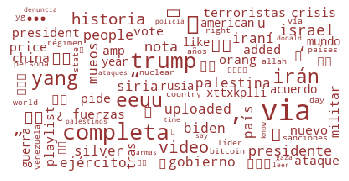

In [186]:
fig = visualize(full_freq_dict)

In [ ]:
fig = visualize(top_user_freq)

## Vectorizing

Using sklearn's CountVectorizer to turn the corpus into a text-term matrix allows us to easily count tokens. CountVectorizer can count n-grams as well as tokens.

In [178]:
def ngram_freq_matrix(list_of_strings,
                      stop_words=None,
                      ngram_range=(1,2)):
    """
    Args: 
       list_of_strings: iterable of strings
       stop_words: a list of stop words or the string 'english' to use a
                   built-in English language stop word list.
                   Default: no stop words
       ngram_range: a single int, or a 2 tuple representing the range of ngrams to count.
                    Default: (1,2); counts 1- and 2- grams.
    Return:
       dataframe of counts indexed by n-gram
    """
    vectorizer = CountVectorizer(analyzer='word',
                                 tokenizer=tweet_tokenizer,
                                 stop_words=stop_words,
                                 ngram_range=ngram_range
                                )
    
    ngram_freq_matrix = count_vectorizer.fit_transform(list_of_strings)
    ngrams = count_vectorizer.get_feature_names()

    return ngram_freq_matrix, ngrams

def count_freq_matrix(ngram_freq_matrix):
    """
    """
    ngram_frequencies = term_freq_matrix.sum(axis=0).tolist()[0]
    freq_dict = dict(zip(terms, term_frequencies))
    
    return (pd.DataFrame(freq_dict, 
                         index_column='ngram',
                         columns=['ngram', 'count'])
                         .sort_values("count", ascending=False))

### Part of speech
Tag tokens with their part of speech for further analysis

In [175]:
def part_of_speech(iterable_of_lists):
    """
    Return a pandas Series of word/part-of-speech pairs.
    """
    all_words = tokenize_iter(iterable_of_lists)
    tokens = remove_stopwords_list(all_words)
    tagged = nltk.pos_tag(tokens)
    part_of_speech = dict(tagged)
    
    return pd.Series(part_of_speech)

In [176]:
pos = part_of_speech(list_df.head(5))
pos

america         RB
way             NN
government      NN
treats         NNS
people         NNS
              ... 
ватному        NNP
выгодная       NNP
партнерская    NNP
рунете         NNP
повлияет       NNP
Length: 13059, dtype: object

In [ ]:
def vectorize(df):
    """Convert a list of tokens to a matrix of token counts."""
    
    vectorizer = CountVectorizer()
    frequency_matrix = vectorizer.fit_transform(df)
    
    # Sum all the frequencies for each word
    total_count = np.sum(frequency_matrix, axis=0)
    
    # Squeeze to remove single-dimensional entries
    frequency = np.squeeze(np.asarray(sum_frequencies))
    
    # Make a dataframe of the words and their frequencies
    frequency_df = pd.DataFrame([frequency], columns=vectorizer.get_feature_names()).transpose()
    return frequency_df

In [ ]:
def plot(word_frequency):
    """
    """
    labels = word_frequency[0][1:51].index
    title = 'Word Frequency'
    
    
    plt.figure(figsize=(10,5))
    plt.bar(np.arange(50), word_frequency[0][1:51], width = 0.8, color = sns.color_palette("bwr"), alpha=0.5, 
            edgecolor = "black", capsize=8, linewidth=1);
    plt.xticks(np.arange(50), labels, rotation=90, size=14);
    plt.xlabel("Word");
    plt.ylabel("Frequency", size=14);
    plt.title(title, size=18)
    plt.grid(False);
    plt.gca().spines["top"].set_visible(False);
    plt.gca().spines["right"].set_visible(False);
    plt.show() 

## Latent Dirichlet Allocation

Tutorial: https://scikit-learn.org/stable/auto_examples/applications/plot_topics_extraction_with_nmf_lda.html#

In [ ]:
import sklearn
from sklearn.decomposition import NMF
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import Normalizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [ ]:
# suggested scale
n_samples = 2000
n_features = 1000
n_components = 10
n_top_words = 20

In [ ]:
user_tweets = (iran
            .loc[:][['tweetid','userid','tweet_text']]

In [ ]:
def split(data):
    X_train, X_test, y_train, y_test = train_test_split(data.tweet, table.sentiment, test_size=0.2, shuffle=True)
    return X_train, X_test, y_train, y_test